# Anomaly detection in GPU data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import pickle
import time
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.figsize'] = [14.0, 5.5]
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 17

## Data processing

In [3]:
with open('functimes_combined.dat', "r") as f:
    raw_data = [x.strip("\n").split() for x in f.readlines()]

In [281]:
# from collections import defaultdict

# run_time_dic = defaultdict(list)
# for i in raw_data:
#     func_name = []
#     for j in range(len(i)):
#         if not i[j].isdigit(): # get the func name
#             func_name.append(i[j])
#         else:
#             runtime = [int(x) for x in i[j:]]
#             key = "_".join(func_name).strip('\"')
#             # using defaultdict in case we encounter repeated keys
#             # if a key already exists, then the new runtime list will append to the existing list
#             run_time_dic[key].append(runtime) 
#             break # exit the loop once we find the position of the first numeric element

In [ ]:
run_time = {}
for i in raw_data:
    func_name = []
    for j in range(len(i)):
        if not i[j].isdigit(): # get the func name
            func_name.append(i[j])
        else:
            runtime = [int(x) for x in i[j:]]
            key = "_".join(func_name).strip('\"')
            # if a key already exists, then the new runtime list will append to the existing list
            value = run_time.get(key)
            if value == None:
                run_time[key] = runtime
            else:
                run_time[key] = value.append(runtime)
    
            break # exit the loop once we find the position of the first numeric element

We see that the length of` (run_time)` isn't equal to the raw data

In [461]:
len(run_time), len(raw_data)

(531, 533)

We can collect the function name and check if anything is wrong:

In [277]:
fun_name = []

for i in raw_data:
    func_name = []
    for j in range(len(i)):
        if not i[j].isdigit(): 
            func_name.append(i[j]) # get the func name
    key = "_".join(func_name).strip('\"')
    fun_name.append(key)

In [374]:
for name, i in zip(fun_name, range(len(fun_name))):
    try:
        run_time[name]
    except:
        print(name, i)

TOTAL 82
 354


If we check the original data file we will notice this is really the case. No runtime data follows `TOTAL`. And their is a blank entry in line 354.

Next let's select the entries called most times:

In [379]:
i = 0 
len_list = []
for key, value in run_time.items():
    len_list.append(len(run_time[key]))

In [380]:
df_len = pd.DataFrame(len_list, index=run_time.keys())
df_len = df_len.reset_index()
df_len = df_len.rename(columns={"index": 'func_name', 0:'call_times'})

In [381]:
df_len = df_len.sort_values('call_times', ascending = False)

In [397]:
df_len.head(10)

,func_name,call_times
224,OpenACC_enqueue_data_transfer_(HtoD),4532940
484,MPI_Type_size(),2329304
116,OpenACC_create,2309544
529,OpenACC_delete,2309270
166,OpenACC_enqueue_upload,1937265
521,Stream_Synchronize,1929195
202,OpenACC_wait,1715497
413,MPI_Waitany(),1685640
44,MPI_Start(),1675360
97,Memory_copy_Host_to_Device,1616603


In [391]:
df_freq = df_len[df_len['call_times'] > 10000]
subset = df_freq.sample(frac = 0.5, random_state = 1)

In [457]:
def sample_portion(dic, func, frac = 0.3):    
    func_runtime = dic[func]
    # total length of the sample
    length = int(len(func_runtime) * frac)
    # select where to start taking the data
    start_position = np.random.randint(0, (len(func_runtime) - length))
    sample_runtime = func_runtime[start_position : start_position + length]
    df_sample = pd.DataFrame({'run_time' : sample_runtime})
    df_sample.name = func
    
    return df_sample   

In [436]:
i = np.random.randint(len(subset))
func_name = subset.iloc[i].func_name
sample = sample_portion(run_time, func_name)

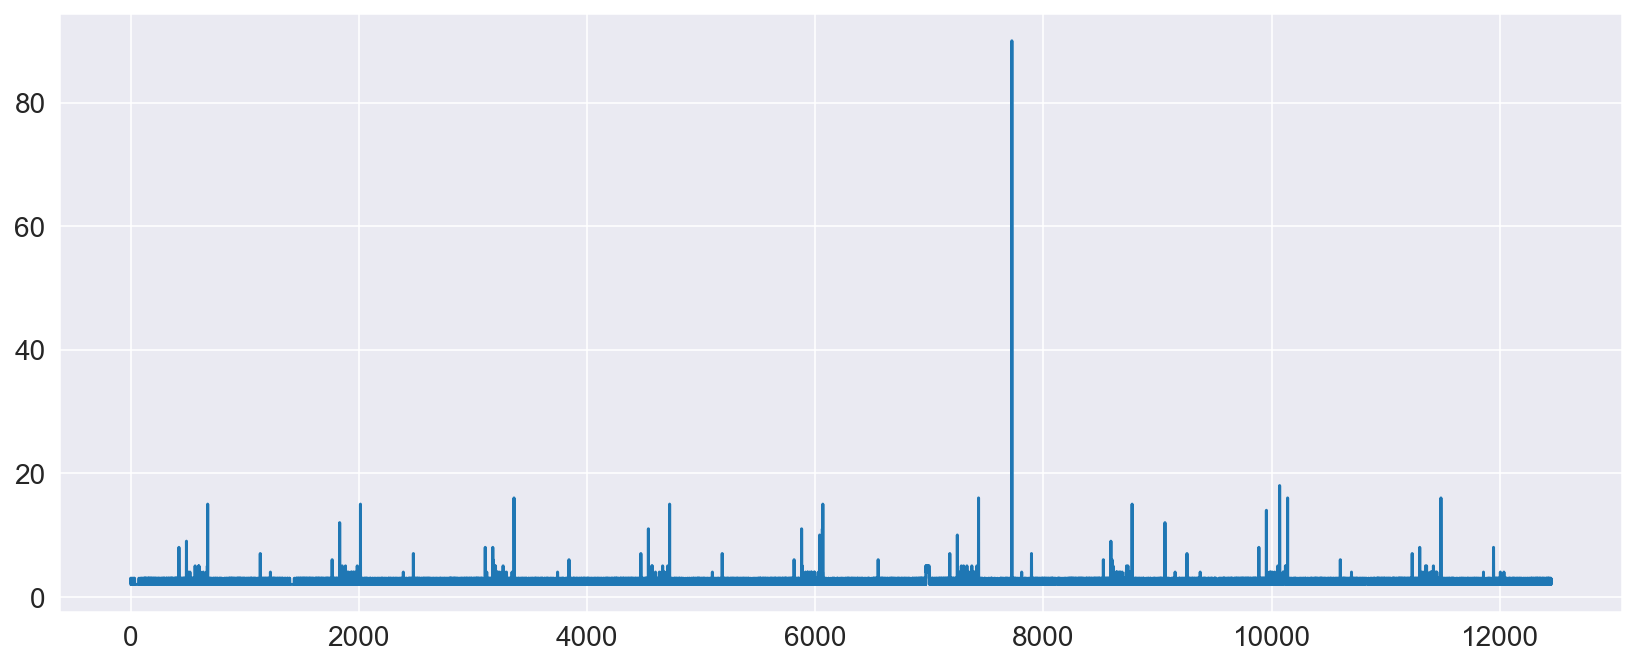

In [439]:
sample.run_time.plot();

In [441]:
sample.index

RangeIndex(start=0, stop=12451, step=1)

## Moving Gaussian

In [444]:
def moving_gaussian(df, window_frac = 0.2, c = 6, plot = True):
    window = int(window_frac * len(df))
    mean = df.run_time.rolling(window = window).mean()
    mean.iloc[:(window-1)] = mean.iloc[window]
    std = df.run_time.rolling(window = window).std()
    std.iloc[:(window-1)] = std.iloc[window]

    upper = mean + c * std
    lower = mean - c * std

    a1 = df.run_time > upper
    a2 = df.run_time < lower
    
    anomalies = np.logical_or(a1, a2)
    normal = np.logical_not(anomalies)
    outlier = df[anomalies]
    normal = df[normal]
    
    if plot:
        ratio = len(outlier)/len(df)
        plt.figure()
        if ratio >= 0.01:
            plt.title("Gaussian, outlier_ratio={:.2f}, c={}, window={}".format(ratio, c, window))
        else:
            plt.title("Gaussian, {} outliers in {} points, c={}, window={}".format(len(outlier), len(df), 
                                                                               c, window))
        
        g = plt.scatter(normal.index,  normal['run_time'], c='green', s=15, edgecolor='k')
        h = plt.scatter(outlier.index, outlier['run_time'], c='red', s=55, edgecolor='k')
        plt.xlabel('data_points')
        plt.ylabel('run_time')
        plt.axis('tight')
        plt.legend([g, h],["Normal","Outlier"])
        plt.show()
    
    return outlier, normal

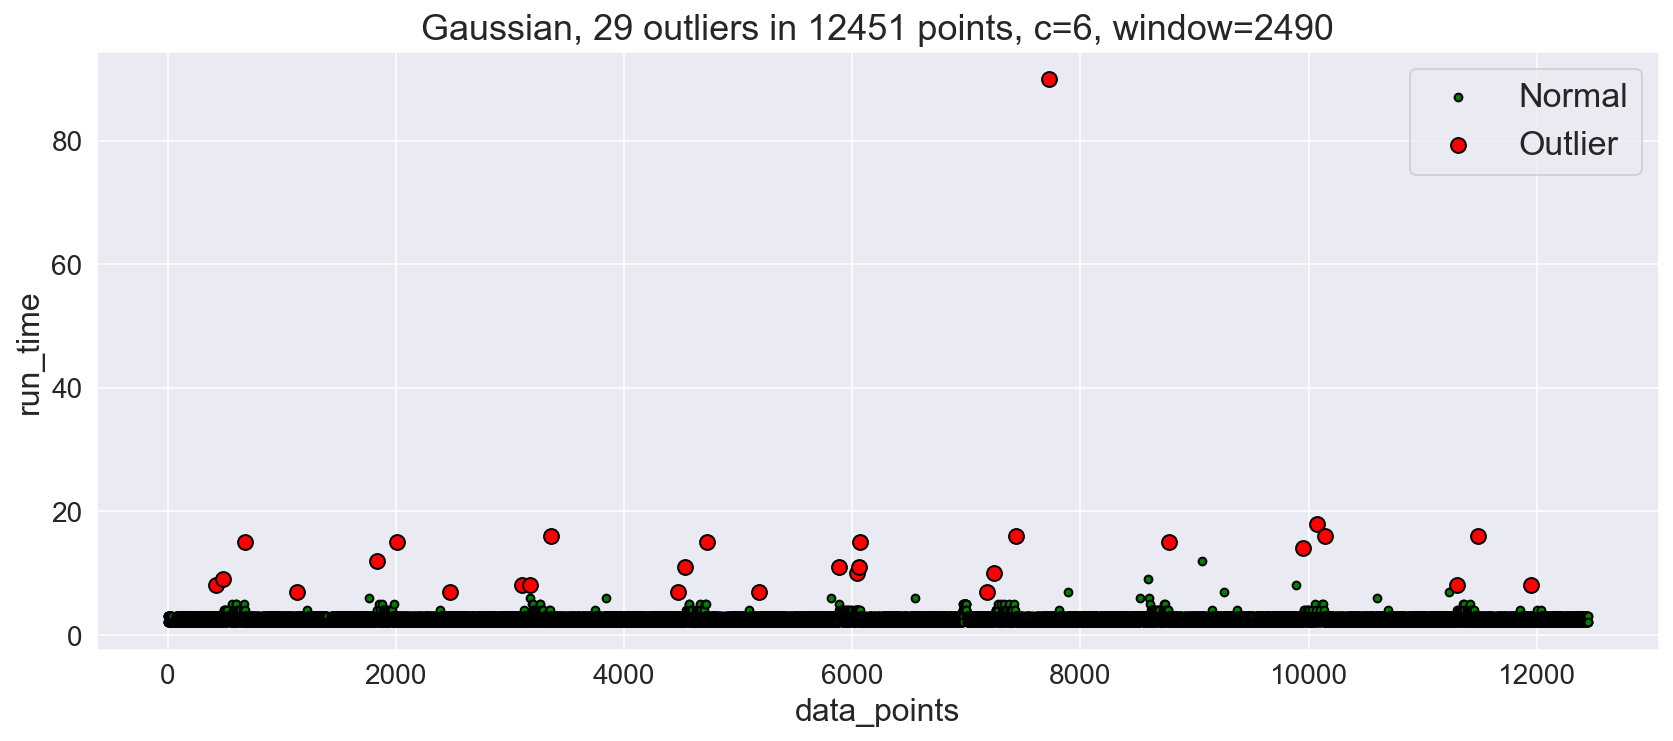

In [445]:
moving_gaussian(sample, plot=True);

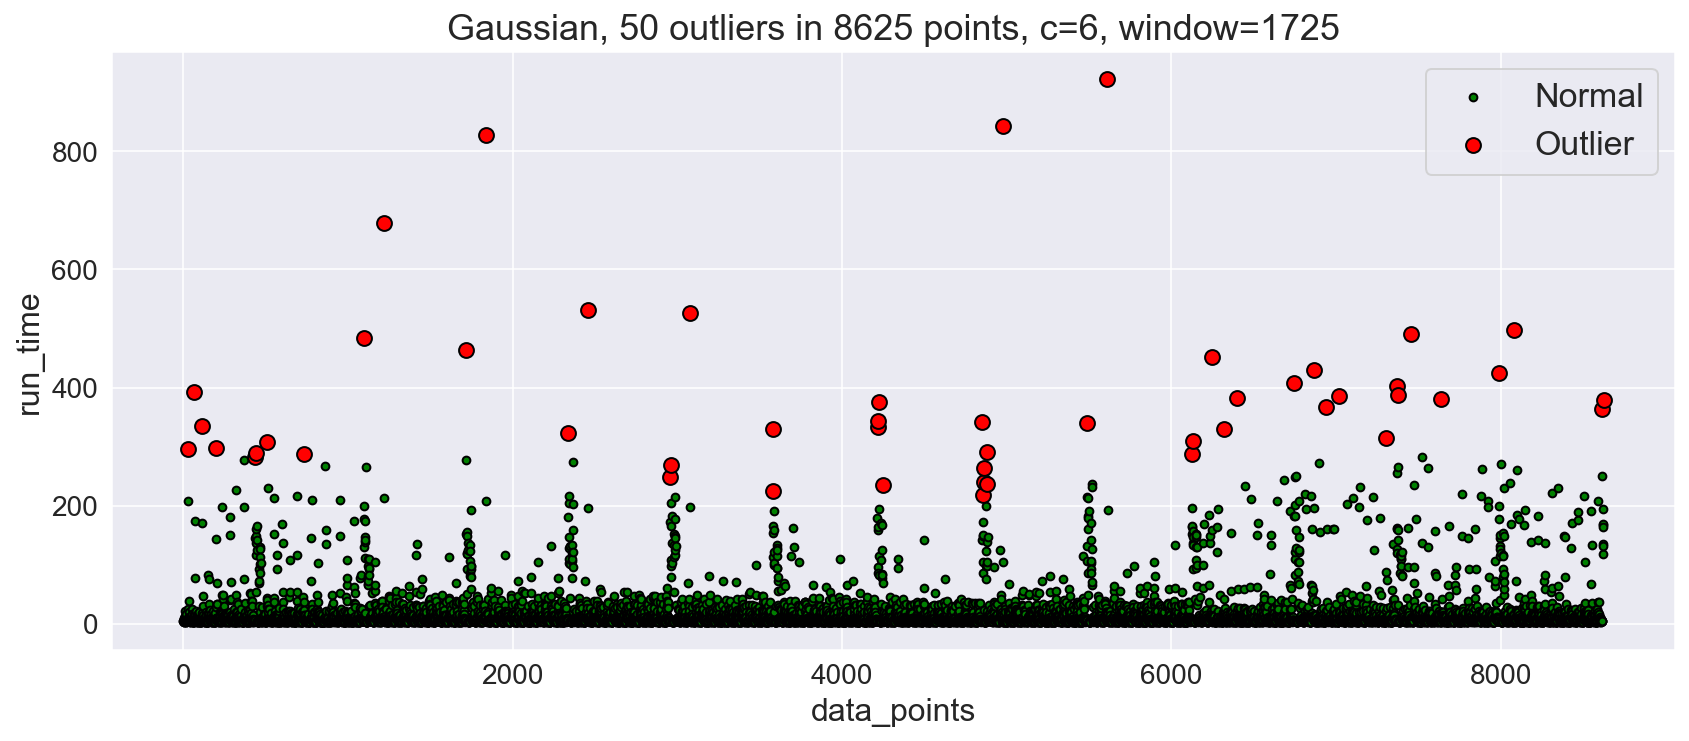

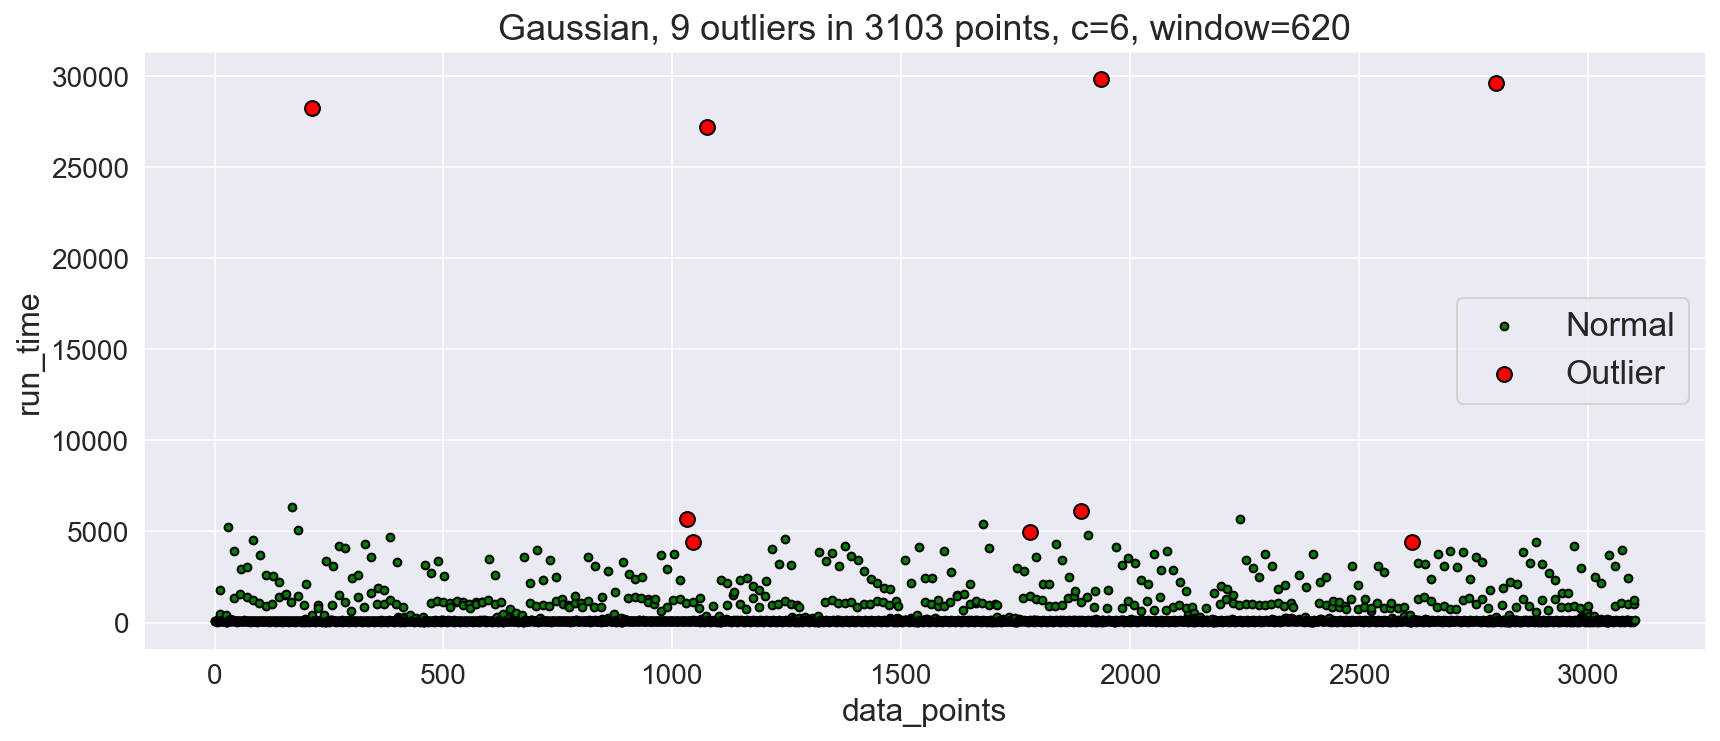

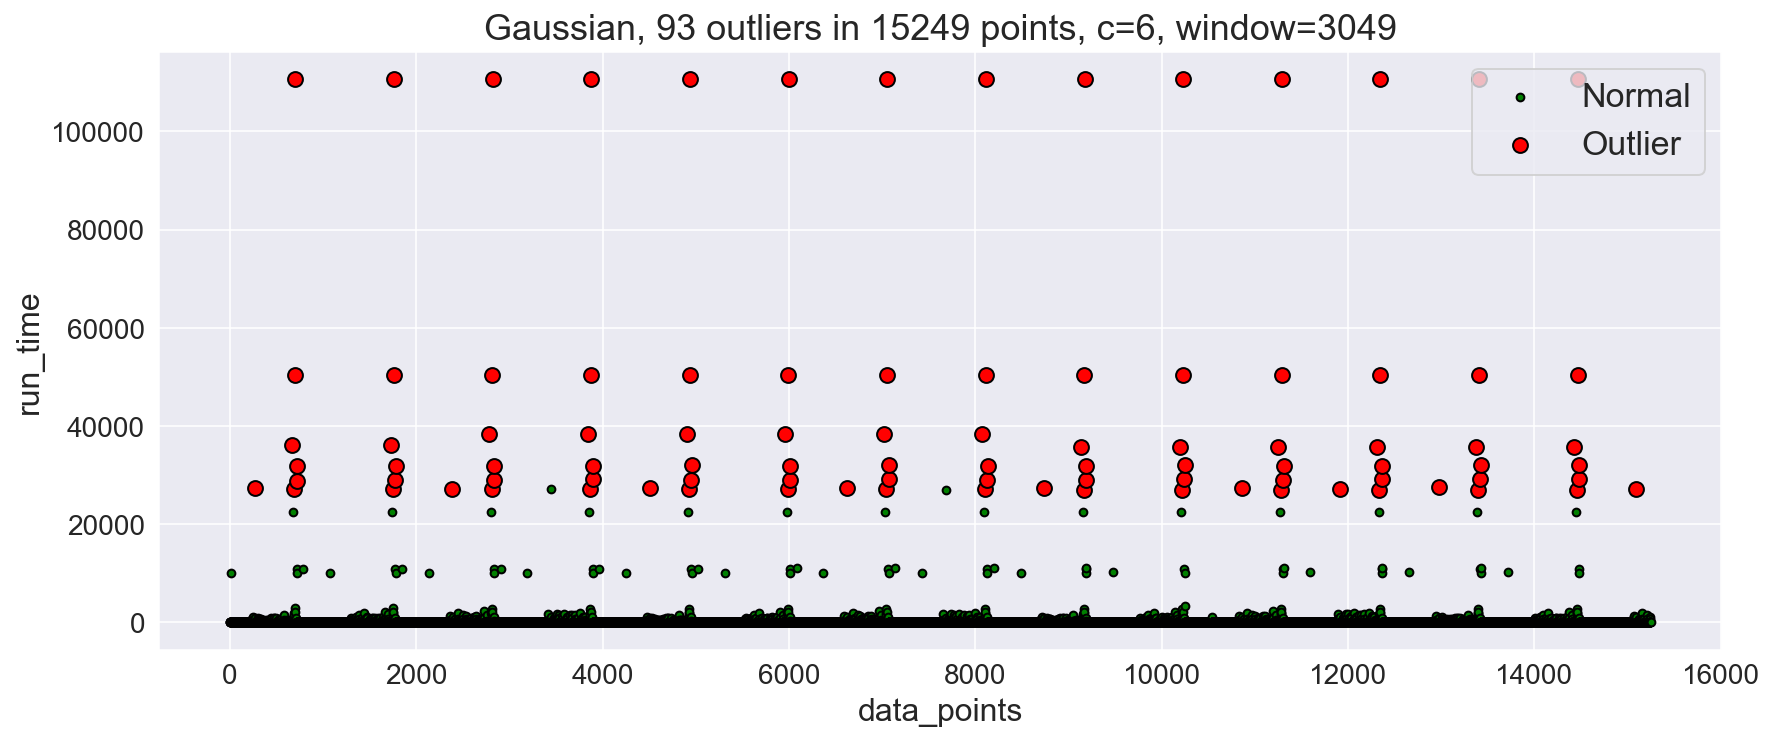

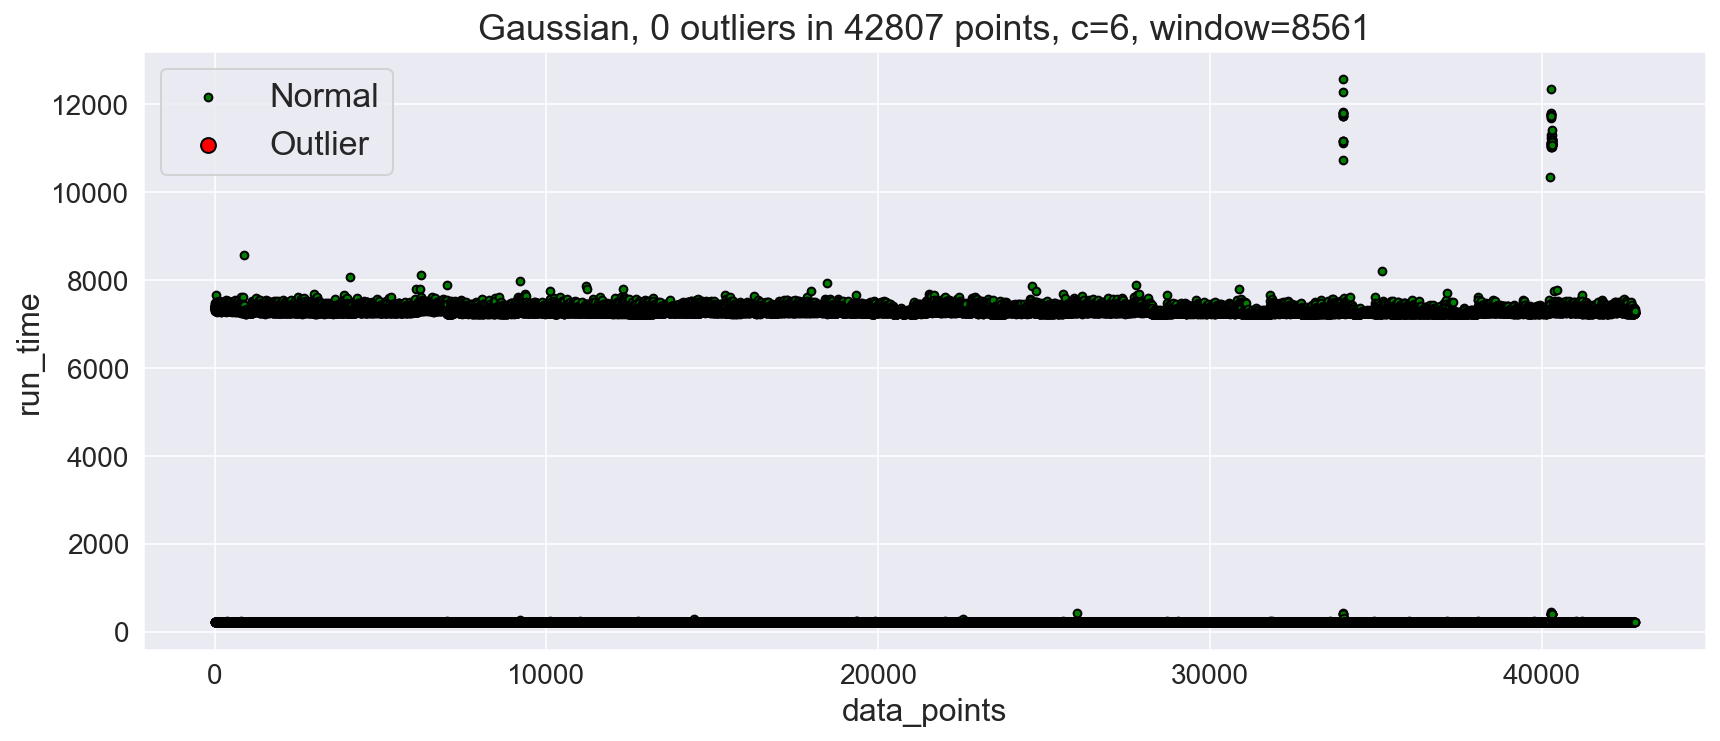

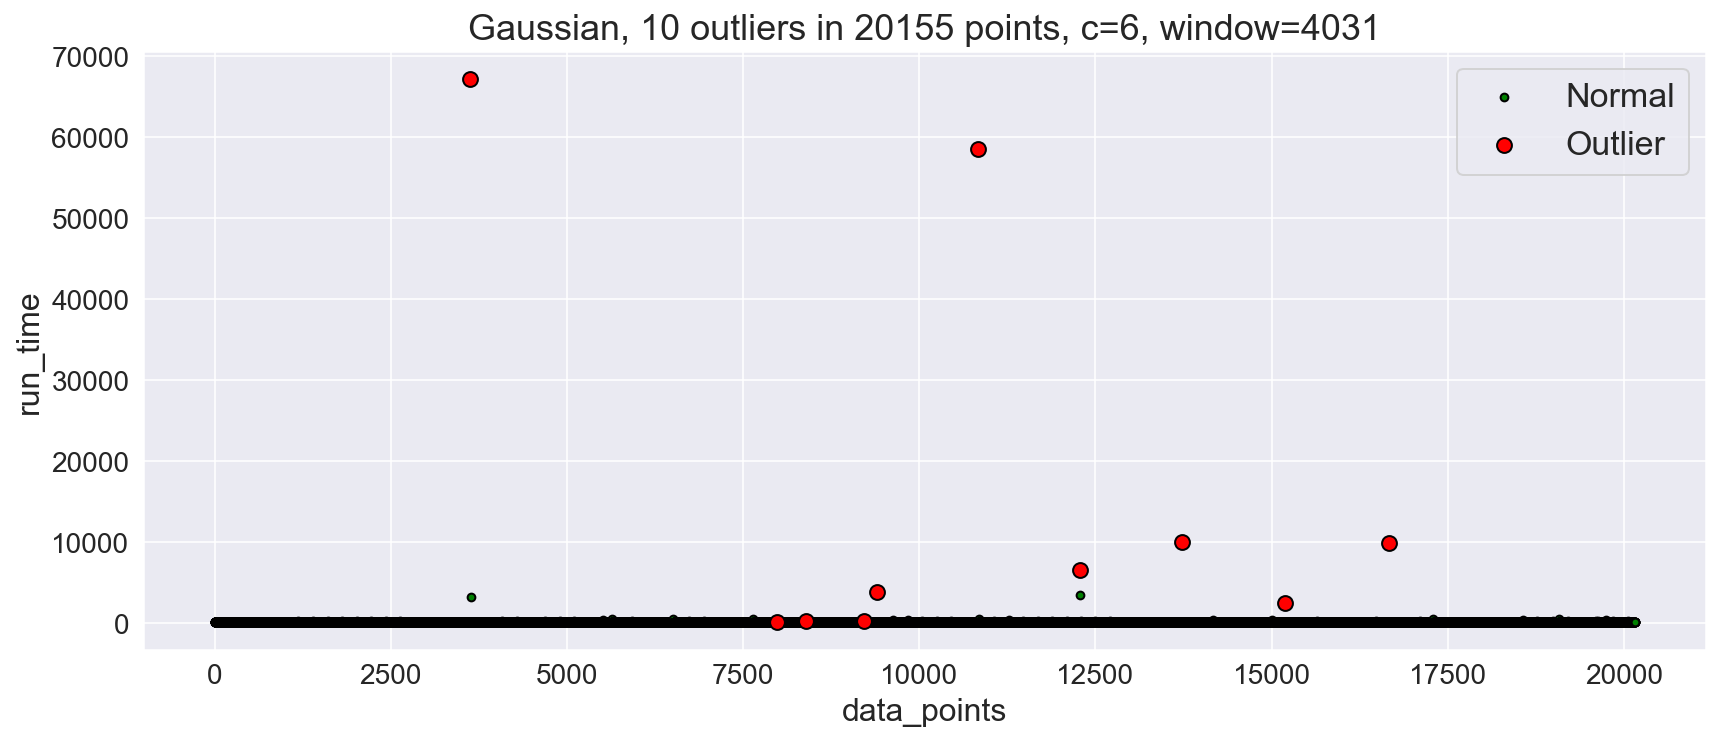

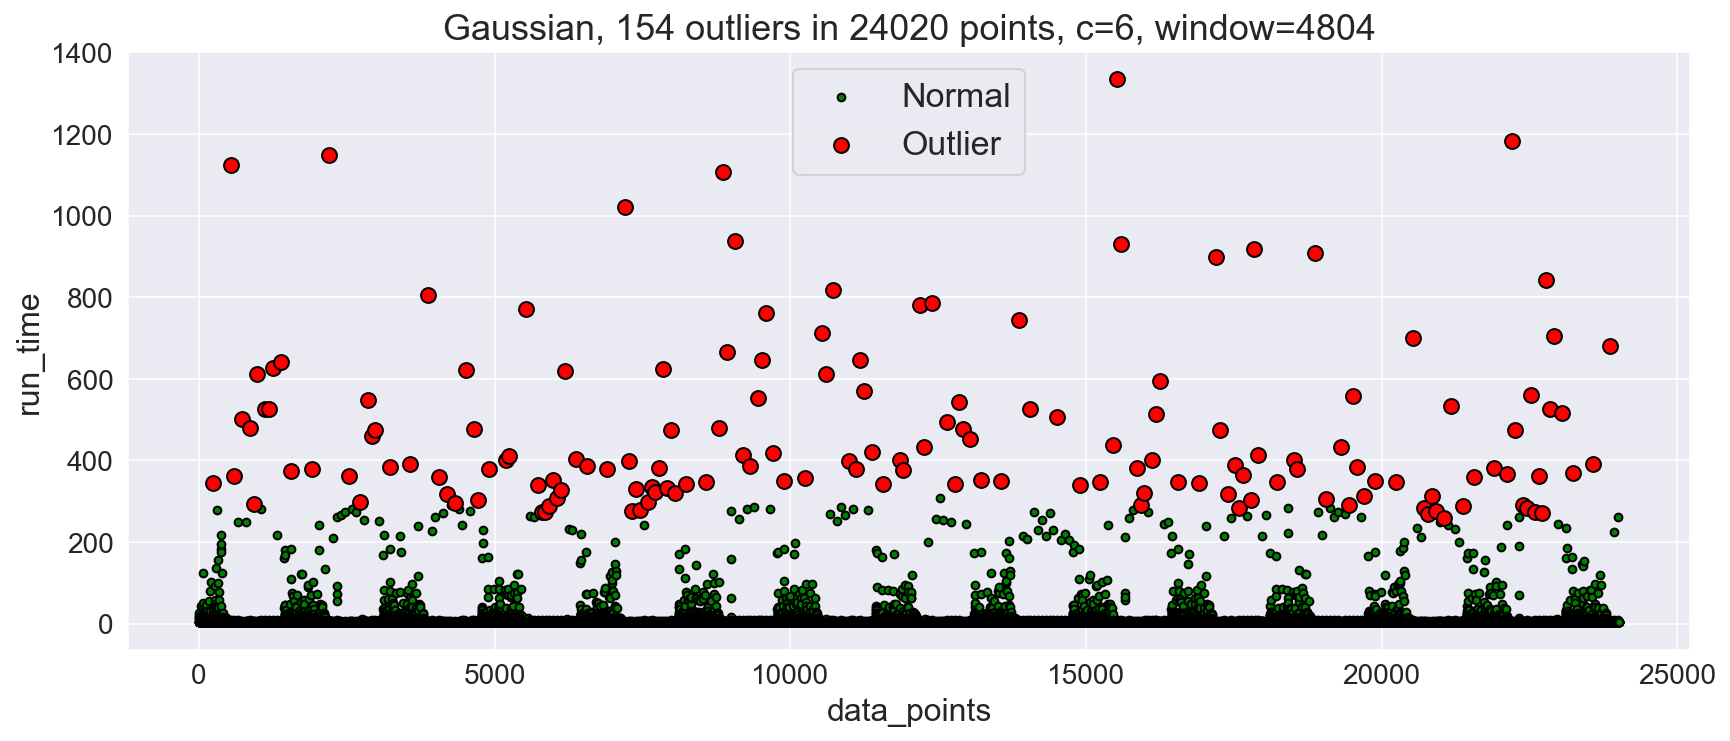

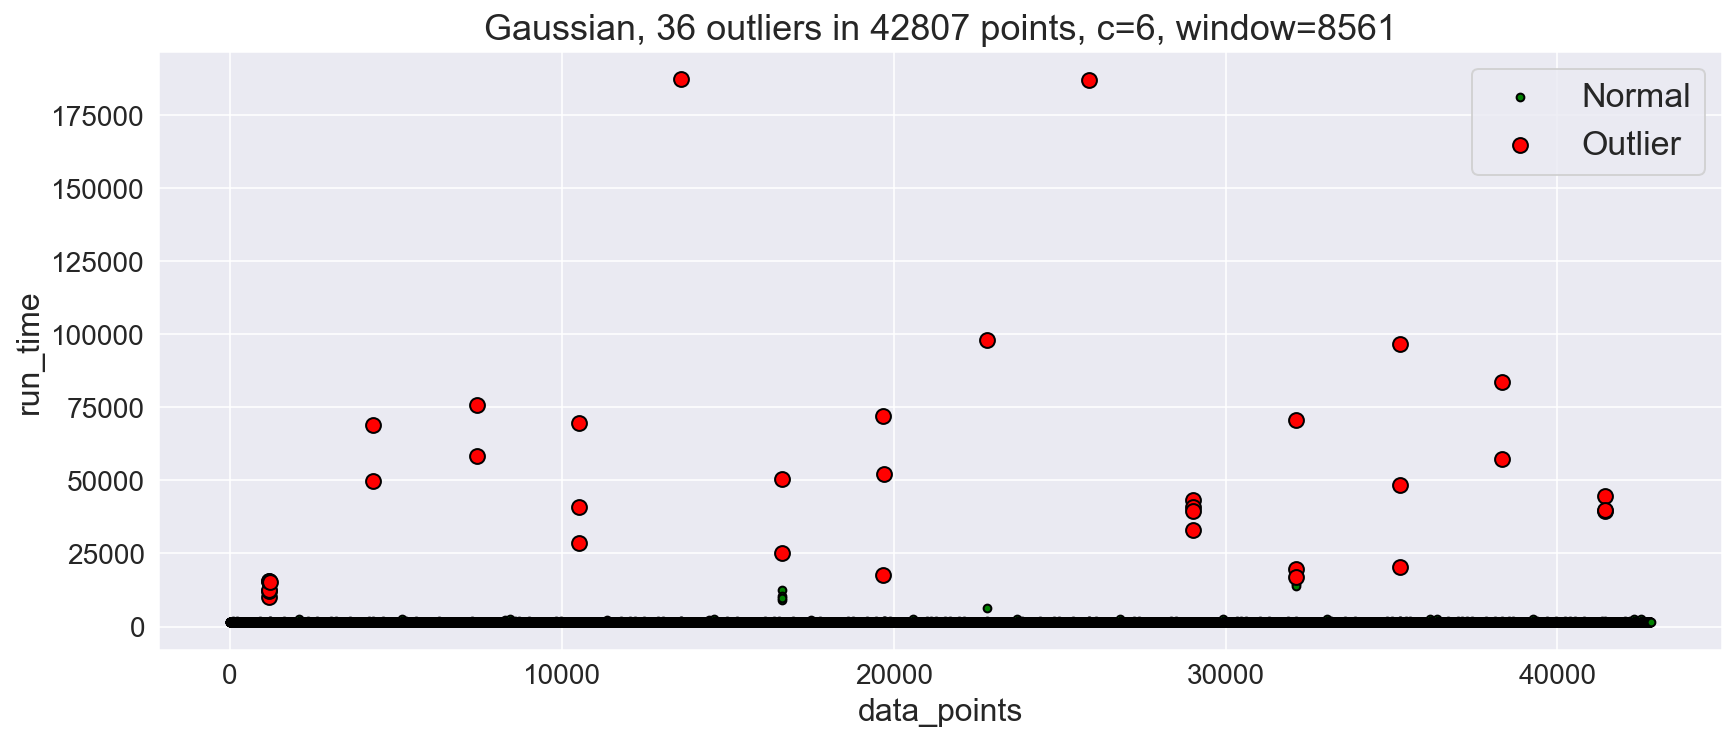

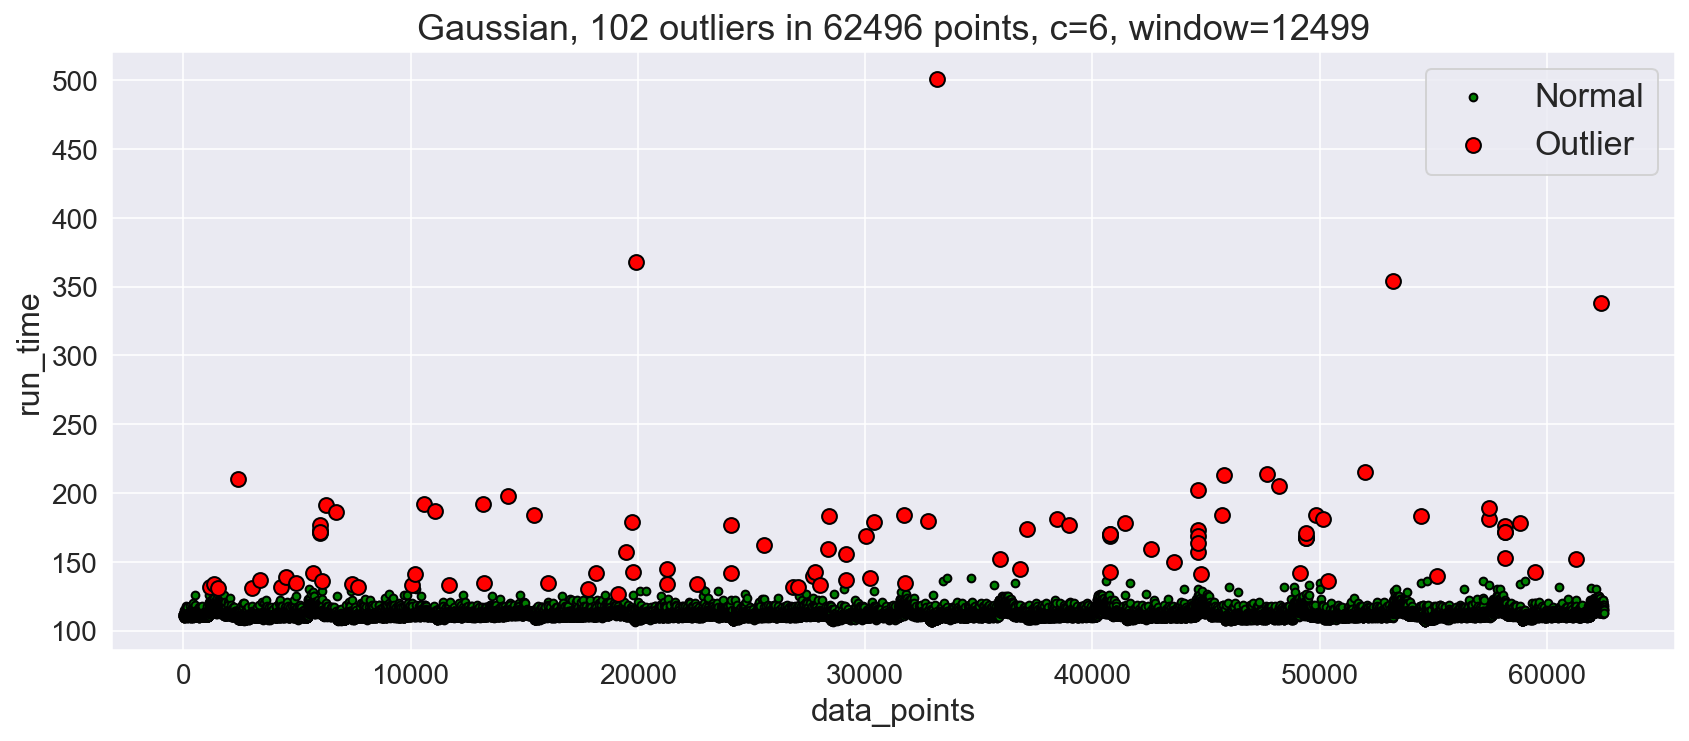

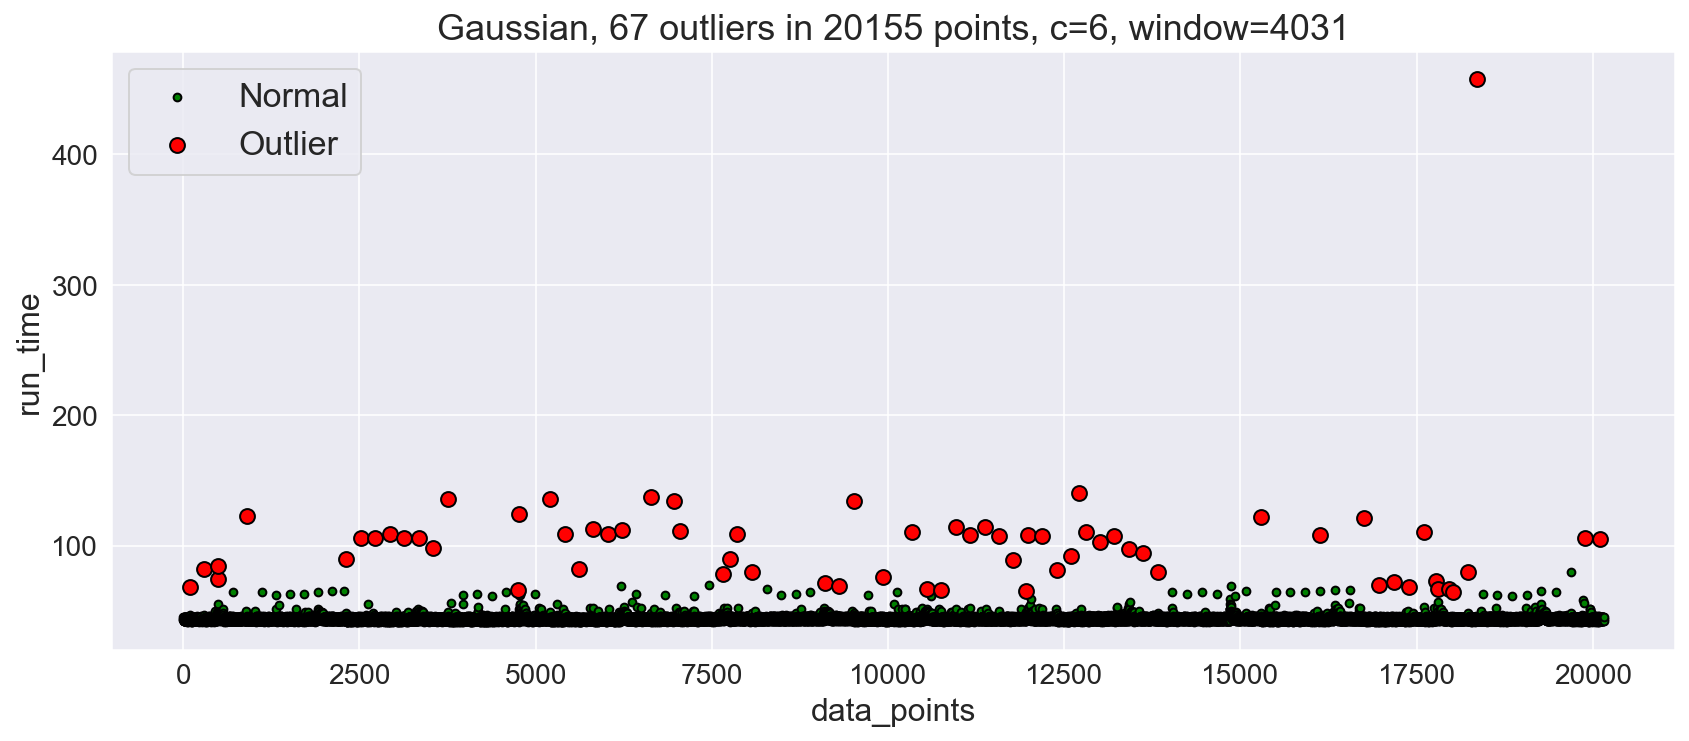

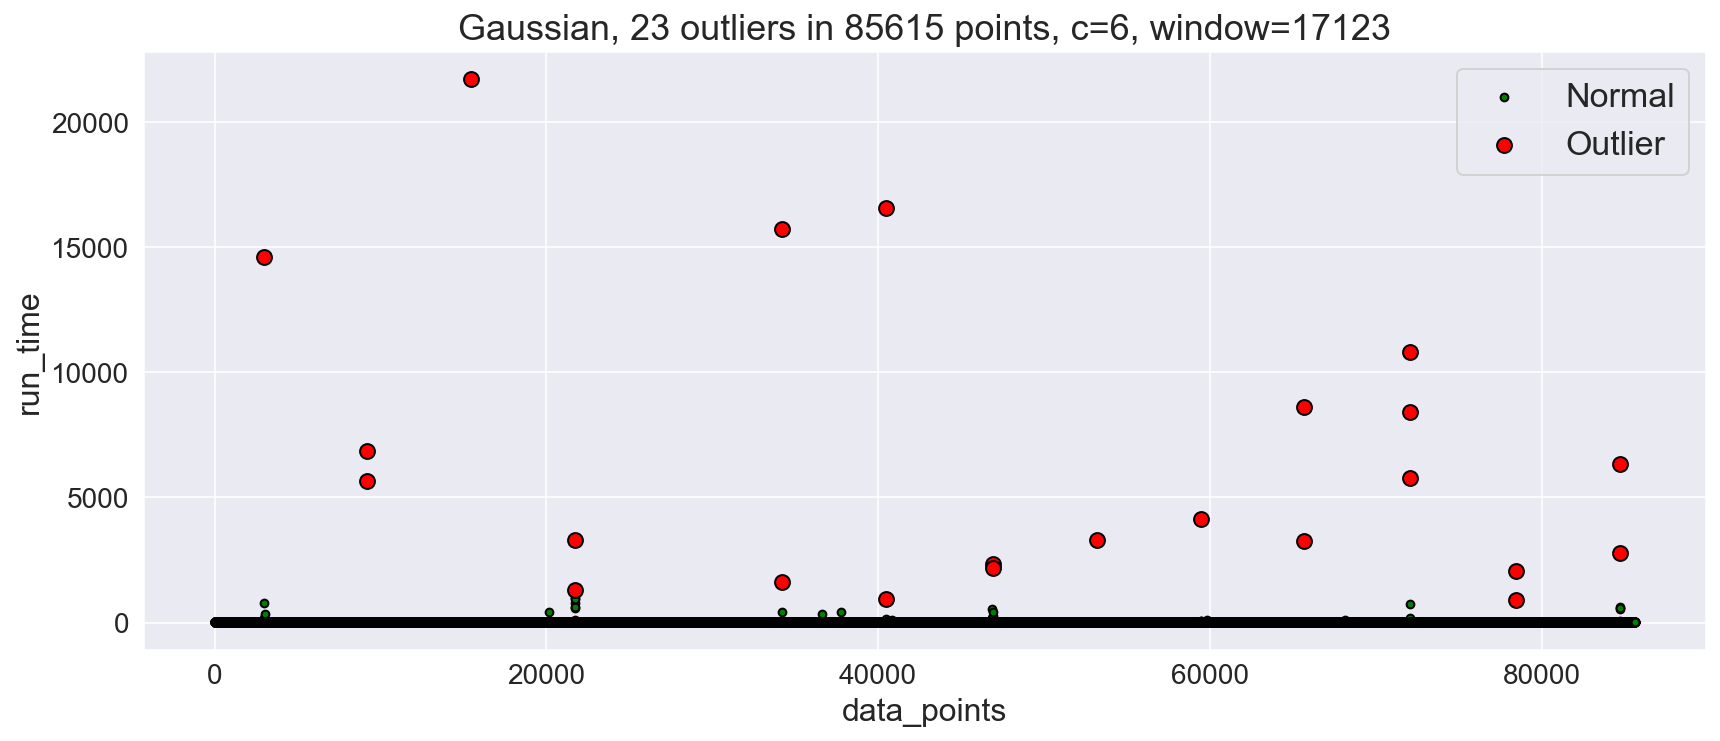

total time used: 5.52160120010376


In [460]:
start = time.time()
for i in range(10): # test 10 random samples
    np.random.seed(i)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    #print(j, func_name)
    sample = sample_portion(run_time, func_name)
    moving_gaussian(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

## Moving Quantile Range

In [464]:
def moving_quantile(df, window_frac = 0.15, c = 3, plot=True):
    window = int(window_frac * len(df))
    q1 = df.run_time.rolling(window = window).quantile(0.1) # here we are more extreme
    q3 = df.run_time.rolling(window = window).quantile(0.9)
    q1.iloc[:(window-1)] = q1.iloc[window]
    q3.iloc[:(window-1)] = q3.iloc[window]

    upper = q3 + c * (q3 - q1)
    lower = q1 - c * (q3 - q1)

    a1 = df.run_time > upper
    a2 = df.run_time < lower
    anomalies = np.logical_or(a1, a2)
    normal = np.logical_not(anomalies)
    outlier = df[anomalies]
    normal = df[normal]
    
    ratio = len(outlier)/len(df)
    if plot:
        plt.figure()
        if ratio >= 0.01:
            plt.title("Tukey, outlier_ratio={:.2f}, c={}, window={}".format(ratio, c, window), fontsize=16)
        else:
            plt.title("Tukey, {} outliers in {} points, c={}, window={}".format(len(outlier), len(df), 
                                                                               c, window), fontsize=16)
        
        g = plt.scatter(normal.index,  normal['run_time'], c='green', s=15, edgecolor='k')
        h = plt.scatter(outlier.index, outlier['run_time'], c='red', s=55, edgecolor='k')
        #plt.xlabel('timestamp', fontsize=15)
        plt.ylabel('run_time', fontsize=15)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.axis('tight')
        plt.legend([g, h],["Normal","Outlier"], prop={'size': 15})
        plt.show()
    
    return outlier, normal

In [465]:
start = time.time()
for i in range(10): # test 10 random samples
    np.random.seed(i)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    #print(j, func_name)
    sample = sample_portion(run_time, func_name)
    moving_quantile(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

TypeError: moving_quantile() got an unexpected keyword argument 'plot'